# Intelligent Flow: Leveraging Machine Learning  for Urban Traffic Management

## Project Objective and Goal:
The main goal is to leverage machine learning techniques to enhance urban traffic management in Heidelberg by predicting traffic intensity through various locations and times.

## Research Question:
How can we accurately predict traffic intensity variations across different times and locations in Heidelberg using machine learning models?

## Machine Learning Aim:
To apply and evaluate SARIMAX and Prophet models on traffic data, tuned to predict daily, weekly, and business-day traffic intensities effectively, thereby assisting in better urban planning and congestion management.

## Dataset 
Traffic cameras in the city of Heidelberg
The dataset contains an observation of the traffic flow at a specific place and time. It contains current and past measurements from traffic cameras in the city of Heidelberg (measurement interval: 15 min).
In addition to general location information, each dataset contains, if available, information on the number of vehicles and vehicle types measured, the average distance between vehicles and their passing time.
A detailed description of the dataset,the specification, and the raw data can be found here: 
https://ckan.datenplattform.heidelberg.de/de/dataset/mobility_main_trafficcamera
<br>In the accuired traffic data the volume of traffic is represented as the count of the number of vehicles passing every 15 mins. Traffic volumes, during the morning weekday rush hour, are used as an illustrative example: plot 

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
 

from matplotlib import pyplot as plt
from datetime import datetime

#sklearn
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Import Functions
from FP_Functions import * 


# pmdarima
from pmdarima import ARIMA
from pmdarima import auto_arima

# statsmodels
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

# skforecast
from skforecast.Sarimax import Sarimax
from skforecast.ForecasterSarimax import ForecasterSarimax
from skforecast.model_selection_sarimax import backtesting_sarimax
from skforecast.model_selection_sarimax import grid_search_sarimax
from sklearn.metrics import mean_absolute_error

import warnings

from sklearn.metrics import mean_squared_error
from math import sqrt

import prophet
from prophet import Prophet

from scipy.stats import uniform

import mango
from mango import Tuner, scheduler

import pmdarima as pm

%matplotlib inline
warnings.filterwarnings("ignore")
plt.rcParams['figure.figsize'] = (20, 8)


In [4]:
Bergheimer_Straße_B37 ='b95871b2-7de0-46b1-b377-db497250f8a0.csv'
data = pd.read_csv(Bergheimer_Straße_B37)

### Initial analysis and data wrangling 

In [5]:
null =[col for col in data.columns if data[col].isna().sum() == data.shape[0]]
data = data.drop(columns = null)

In [6]:
col_to_check = ['fiwareServicePath','entityId','entityType','addressLocality','addressCountry']
for col in col_to_check:
    print(data[col].unique())

['/main/trafficcamera']
['urn:ngsiv2:TrafficFlowObserved:2d458741-2a9a-45ba-a062-f8a790a976aa']
['TrafficFlowObserved']
['Heidelberg']
['Deutschland']


In [7]:
data = data.drop(columns = col_to_check)
data = data.drop_duplicates()
data = data.reset_index(drop =True)
print(f'The data has {data.shape[0]} rows and {data.shape[1]} columns')
data.head(5)

The data has 116471 rows and 11 columns


,_id,recvTime,latitude,postalCode,vehicleType,longitude,dateObservedTo,dateObserved,dateObservedFrom,intensity,streetAddress
0,1,2022-11-03T14:05:24.567Z,49.408167,69115,car,8.66825,2022-11-03T13:55:00.000Z,2022-11-03T13:55:00.000Z,2022-11-03T13:40:00.000Z,243,Bergheimer Straße B37
1,2,2022-11-03T14:05:24.617Z,49.408167,69115,motorcycle,8.66825,2022-11-03T13:55:00.000Z,2022-11-03T13:55:00.000Z,2022-11-03T13:40:00.000Z,5,Bergheimer Straße B37
2,3,2022-11-03T14:05:24.666Z,49.408167,69115,van,8.66825,2022-11-03T13:55:00.000Z,2022-11-03T13:55:00.000Z,2022-11-03T13:40:00.000Z,44,Bergheimer Straße B37
3,4,2022-11-03T14:05:24.666Z,49.408167,69115,lorry,8.66825,2022-11-03T13:55:00.000Z,2022-11-03T13:55:00.000Z,2022-11-03T13:40:00.000Z,46,Bergheimer Straße B37
4,5,2022-11-03T14:15:20.829Z,49.408167,69115,car,8.66825,2022-11-03T14:10:00.000Z,2022-11-03T14:10:00.000Z,2022-11-03T13:55:00.000Z,273,Bergheimer Straße B37


#### Converting formats

In [8]:
data.dtypes

_id                   int64
recvTime             object
latitude            float64
postalCode            int64
vehicleType          object
longitude           float64
dateObservedTo       object
dateObserved         object
dateObservedFrom     object
intensity             int64
streetAddress        object
dtype: object

In [9]:
# Converting the types
data['recvTime'] = pd.to_datetime(data['recvTime'])
data['dateObserved'] = pd.to_datetime(data['dateObserved'])
data['dateObservedFrom'] = pd.to_datetime(data['dateObservedFrom'])
data['dateObservedTo'] = pd.to_datetime(data['dateObservedTo'])

In [10]:
data['hourOfDay'] = data['dateObserved'].dt.hour
data['date'] = data['dateObserved'].dt.date
data['year'] = pd.DatetimeIndex(data['date']).year
data['month'] = pd.DatetimeIndex(data['date']).month
data['days_of_week'] = pd.DatetimeIndex(data['date']).day_name()
data['date'] =pd.to_datetime(data['date'])

In [11]:
data.dtypes

_id                               int64
recvTime            datetime64[ns, UTC]
latitude                        float64
postalCode                        int64
vehicleType                      object
longitude                       float64
dateObservedTo      datetime64[ns, UTC]
dateObserved        datetime64[ns, UTC]
dateObservedFrom    datetime64[ns, UTC]
intensity                         int64
streetAddress                    object
hourOfDay                         int32
date                     datetime64[ns]
year                              int32
month                             int32
days_of_week                     object
dtype: object

In [12]:
data[data['date']== '2022-11-09'].head(5)

,_id,recvTime,latitude,postalCode,vehicleType,longitude,dateObservedTo,dateObserved,dateObservedFrom,intensity,streetAddress,hourOfDay,date,year,month,days_of_week
1730,1731,2022-11-09 07:00:19.789000+00:00,49.408167,69115,car,8.66825,2022-11-09 06:55:00+00:00,2022-11-09 06:55:00+00:00,2022-11-09 06:40:00+00:00,184,Bergheimer Straße B37,6,2022-11-09,2022,11,Wednesday
1731,1732,2022-11-09 07:00:19.871000+00:00,49.408167,69115,motorcycle,8.66825,2022-11-09 06:55:00+00:00,2022-11-09 06:55:00+00:00,2022-11-09 06:40:00+00:00,22,Bergheimer Straße B37,6,2022-11-09,2022,11,Wednesday
1732,1733,2022-11-09 07:00:19.971000+00:00,49.408167,69115,van,8.66825,2022-11-09 06:55:00+00:00,2022-11-09 06:55:00+00:00,2022-11-09 06:40:00+00:00,12,Bergheimer Straße B37,6,2022-11-09,2022,11,Wednesday
1733,1734,2022-11-09 07:00:19.982000+00:00,49.408167,69115,lorry,8.66825,2022-11-09 06:55:00+00:00,2022-11-09 06:55:00+00:00,2022-11-09 06:40:00+00:00,21,Bergheimer Straße B37,6,2022-11-09,2022,11,Wednesday
1864,1865,2022-11-09 07:30:31.954000+00:00,49.408167,69115,car,8.66825,2022-11-09 07:25:00+00:00,2022-11-09 07:25:00+00:00,2022-11-09 07:10:00+00:00,230,Bergheimer Straße B37,7,2022-11-09,2022,11,Wednesday


####  Checking for gaps

In [13]:
data_timegrouped = data.groupby('dateObserved')[['intensity']].sum()
gap = data_timegrouped.asfreq('15min')
gap.isna().sum()

intensity    9870
dtype: int64

In [14]:
mask = gap.isna().any(axis=1)
gap_final = gap.loc[mask,'intensity']
gap_final = pd.DataFrame(gap_final)
gap_final

,intensity
dateObserved,
2022-11-03 15:55:00+00:00,NaN
2022-11-04 10:55:00+00:00,NaN
2022-11-07 01:25:00+00:00,NaN
2022-11-08 00:25:00+00:00,NaN
2022-11-09 04:55:00+00:00,NaN
...,...
2024-02-01 01:10:00+00:00,NaN
2024-02-01 01:40:00+00:00,NaN
2024-02-01 02:25:00+00:00,NaN


In [15]:
gap_reset = gap.reset_index()
gap_reset['dateObserved'] = pd.to_datetime(gap_reset['dateObserved'])
gap_reset['date']=gap_reset['dateObserved'].dt.date

In [16]:
data2022 = data[data['year'] == 2022]
datafil = data[(data['year'] == 2023) | (data['year'] == 2024) & (data['date'] < '2024-01-03')]

datafil_grouped_23_24 = datafil.groupby('dateObserved')[['intensity']].sum()
gap_23_24 = datafil_grouped_23_24.asfreq('15min')
print(f' After reducing the cycle to exactly one year ( 2023/01/03 - 2024/01-02) the data has {gap_23_24.isna().sum().iloc[0]} gaps.')

 After reducing the cycle to exactly one year ( 2023/01/03 - 2024/01-02) the data has 4620 gaps.


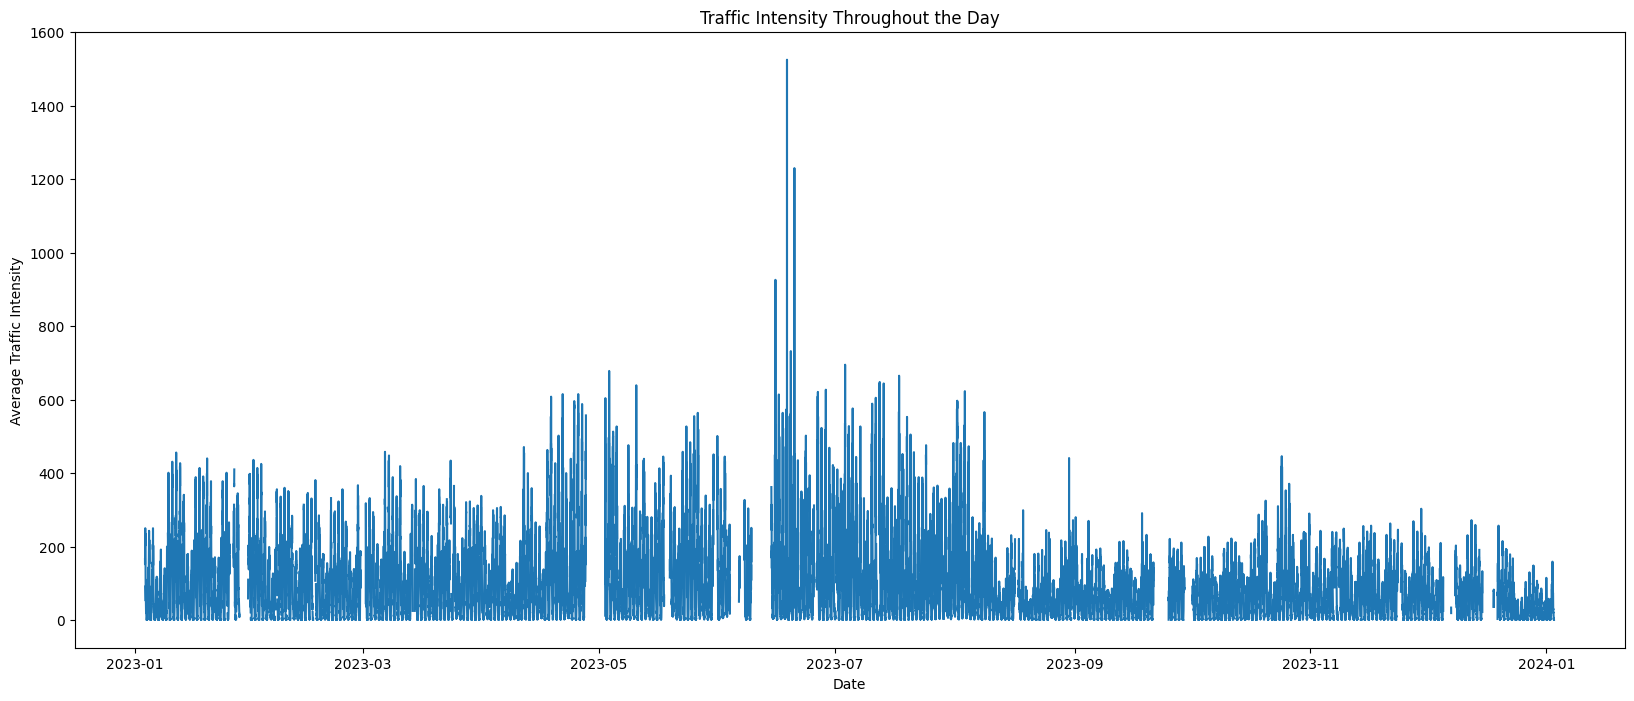

In [17]:
plt.plot(gap_23_24.index, gap_23_24.intensity)
plt.title("Traffic Intensity Throughout the Day")
plt.xlabel('Date')
plt.ylabel('Average Traffic Intensity')
plt.show()

In [18]:
gap_23_24['filled_intensity'] = gap_23_24.apply(lambda row: fill_with_previous_week(row, gap_23_24), axis=1)
gap_23_24['filled_intensity'] = gap_23_24.apply(lambda row: refill_with_previous_week(row, gap_23_24,'filled_intensity' ), axis=1)

Target Date: 2023-01-04 00:40:00+00:00
Matches found: 0
Target Date: 2023-01-04 01:55:00+00:00
Matches found: 0
Target Date: 2023-01-04 02:10:00+00:00
Matches found: 0
Target Date: 2023-01-04 02:25:00+00:00
Matches found: 0
Target Date: 2023-01-04 02:55:00+00:00
Matches found: 0
Target Date: 2023-01-05 01:10:00+00:00
Matches found: 0
Target Date: 2023-01-05 01:40:00+00:00
Matches found: 0
Target Date: 2023-01-05 03:10:00+00:00
Matches found: 0
Target Date: 2023-01-06 00:40:00+00:00
Matches found: 0
Target Date: 2023-01-06 03:40:00+00:00
Matches found: 0
Target Date: 2023-01-07 02:10:00+00:00
Matches found: 0
Target Date: 2023-01-07 03:25:00+00:00
Matches found: 0
Target Date: 2023-01-08 10:25:00+00:00
Matches found: 0
Target Date: 2023-01-08 19:25:00+00:00
Matches found: 0
Target Date: 2023-01-09 00:55:00+00:00
Matches found: 0
Target Date: 2023-01-09 01:55:00+00:00
Matches found: 0
Target Date: 2023-01-09 02:10:00+00:00
Matches found: 0
Target Date: 2023-01-09 02:55:00+00:00
Matches f

In [19]:
gap_23_24['filled_intensity'].isna().sum()

242

In [20]:
mask = gap_23_24['filled_intensity'].isna()
gap_23_24_null = gap_23_24.loc[mask]
gap_23_24_null

,intensity,filled_intensity
dateObserved,,
2023-01-04 00:40:00+00:00,NaN,NaN
2023-01-04 01:55:00+00:00,NaN,NaN
2023-01-04 02:10:00+00:00,NaN,NaN
2023-01-04 02:25:00+00:00,NaN,NaN
2023-01-04 02:55:00+00:00,NaN,NaN
...,...,...
2023-12-31 03:10:00+00:00,NaN,NaN
2023-12-31 03:55:00+00:00,NaN,NaN
2024-01-02 00:55:00+00:00,NaN,NaN


gap_23_24['ffill_intenstiy']= gap_23_24['intensity'].ffill()
gap_23_24['bfil_intensity']=gap_23_24['intensity'].bfill()

In [21]:
mask = gap_23_24.filled_intensity.isna()
null = gap_23_24.loc[mask,:]
null

,intensity,filled_intensity
dateObserved,,
2023-01-04 00:40:00+00:00,NaN,NaN
2023-01-04 01:55:00+00:00,NaN,NaN
2023-01-04 02:10:00+00:00,NaN,NaN
2023-01-04 02:25:00+00:00,NaN,NaN
2023-01-04 02:55:00+00:00,NaN,NaN
...,...,...
2023-12-31 03:10:00+00:00,NaN,NaN
2023-12-31 03:55:00+00:00,NaN,NaN
2024-01-02 00:55:00+00:00,NaN,NaN


In [22]:
gap_23_24[(gap_23_24.index.month == 4) & (gap_23_24.index.day > 24) &(gap_23_24.index.hour > 15) ].asfreq('D')

,intensity,filled_intensity
dateObserved,,
2023-04-25 16:10:00+00:00,257.0,257.0
2023-04-26 16:10:00+00:00,340.0,340.0
2023-04-27 16:10:00+00:00,NaN,308.0
2023-04-28 16:10:00+00:00,NaN,209.0
2023-04-29 16:10:00+00:00,NaN,164.0
2023-04-30 16:10:00+00:00,NaN,223.0


In [23]:
gap_23_24['filled_intensity'] = gap_23_24['filled_intensity'].interpolate(method='time')
gap_23_24['filled_intensity']  = np.ceil(gap_23_24['filled_intensity'])


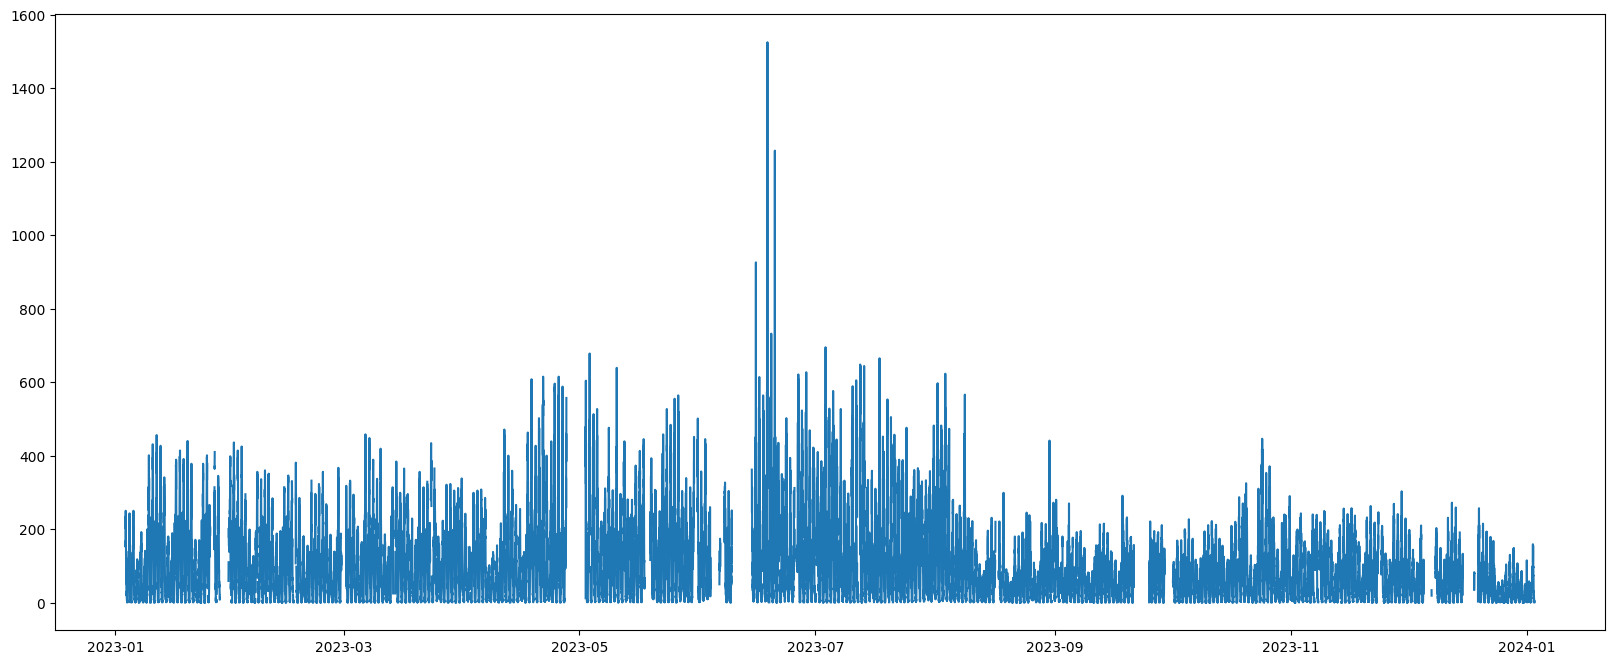

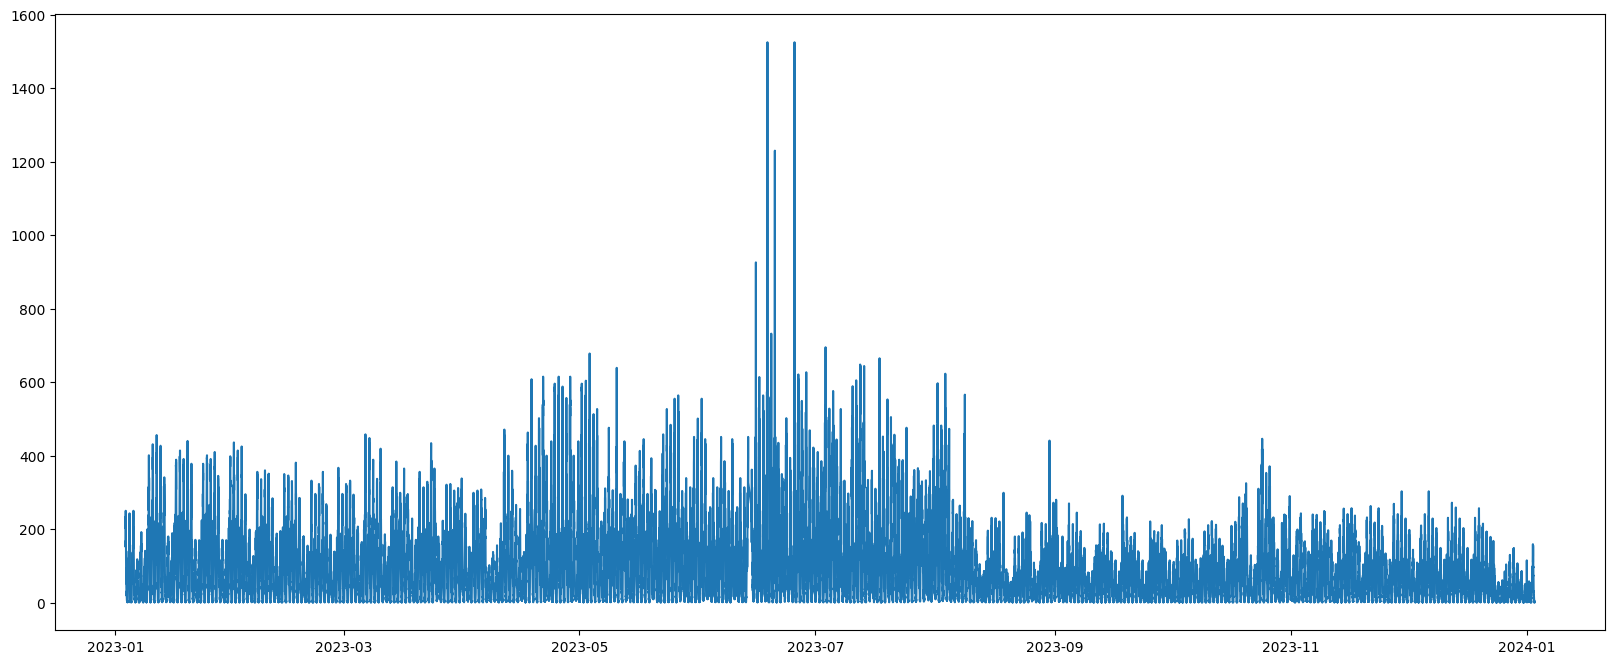

intensity           4620
filled_intensity       0
dtype: int64

In [24]:
plt.plot(gap_23_24.index, gap_23_24.intensity)
plt.show()

plt.plot(gap_23_24.index, gap_23_24.filled_intensity)
plt.show()

gap_23_24.isna().sum()

In [33]:
gap_23_24.to_csv('Bergehimerstr_ML.csv', index=False)

In [26]:
data_preprocessed = gap_23_24.reset_index()
data_preprocessed.dtypes

dateObserved        datetime64[ns, UTC]
intensity                       float64
filled_intensity                float64
dtype: object

## Outliers 
The data consistently does not show a surge in traffic volume due to outliers,unexpected spikes or drops that do not align with usual patterns or known events on specific days, the surge during the summer has been repeated in all the datasrts, these patterns are not outliers but part of the normal variability in traffic flows.

## Exploratory Data Analysis

In [27]:
data_preprocessed['hourOfDay']=data_preprocessed['dateObserved'].dt.hour
data_preprocessed['date']=data_preprocessed['dateObserved'].dt.date
data_preprocessed['date'] = pd.to_datetime(data_preprocessed['date'])
data_preprocessed['year'] = data_preprocessed['date'].dt.year
data_preprocessed['month_number'] = data_preprocessed['date'].dt.month
data_preprocessed['month'] = data_preprocessed['date'].dt.month_name()
data_preprocessed['days_of_week'] = data_preprocessed['date'].dt.day_name()

In [83]:
data_preprocessed.head(4)

,dateObserved,intensity,filled_intensity,hourOfDay,date,year,month_number,month,days_of_week
0,2023-01-03 13:40:00+00:00,166.0,166.0,13,2023-01-03,2023,1,January,Tuesday
1,2023-01-03 13:55:00+00:00,152.0,152.0,13,2023-01-03,2023,1,January,Tuesday
2,2023-01-03 14:10:00+00:00,183.0,183.0,14,2023-01-03,2023,1,January,Tuesday
3,2023-01-03 14:25:00+00:00,201.0,201.0,14,2023-01-03,2023,1,January,Tuesday
4,2023-01-03 14:40:00+00:00,233.0,233.0,14,2023-01-03,2023,1,January,Tuesday


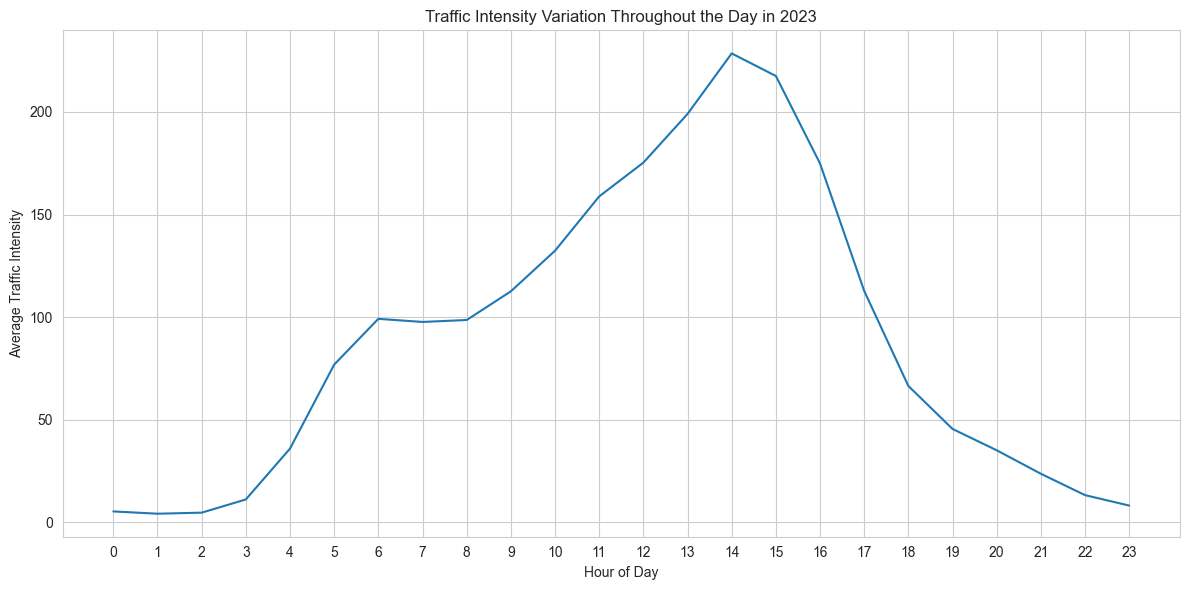

In [28]:
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")
sns.lineplot(x='hourOfDay', y='intensity', data=data_preprocessed[(data_preprocessed['year']==2023)], estimator='mean', errorbar=None)
plt.title('Traffic Intensity Variation Throughout the Day in 2023')
plt.xlabel('Hour of Day')
plt.ylabel('Average Traffic Intensity')
plt.xticks(range(0, 24))
plt.grid(True)
plt.tight_layout()


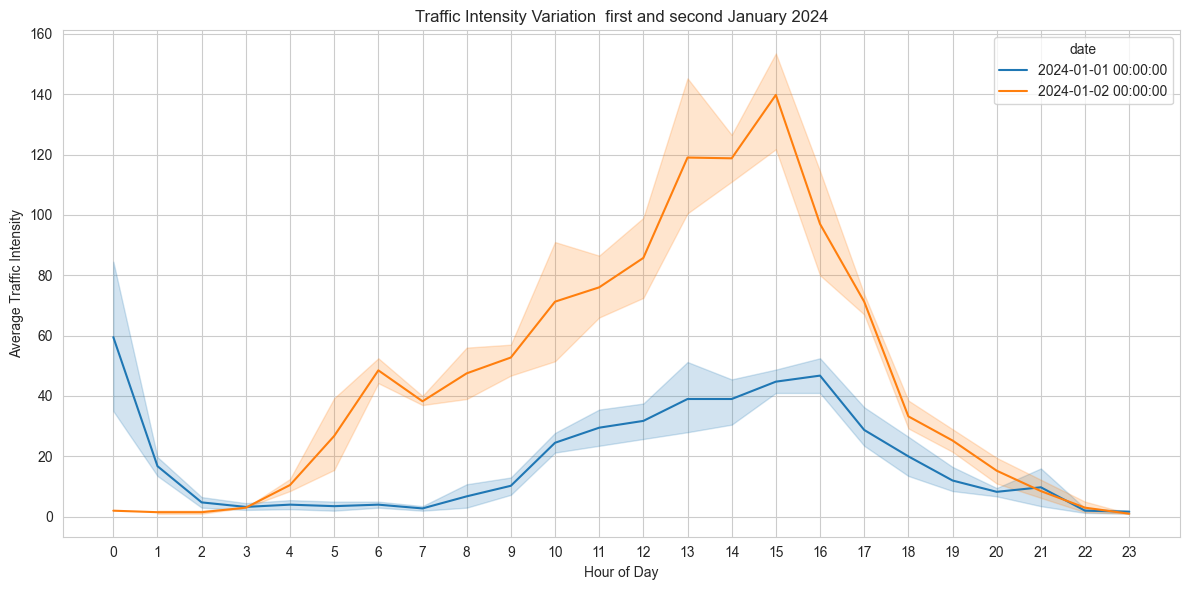

In [29]:
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")
sns.lineplot(x='hourOfDay', y='intensity',hue='date', data=data_preprocessed[(data_preprocessed['year']==2024)], estimator='mean')
plt.title('Traffic Intensity Variation  first and second January 2024')
plt.xlabel('Hour of Day')
plt.ylabel('Average Traffic Intensity')
plt.xticks(range(0, 24))
plt.grid(True)
plt.tight_layout()


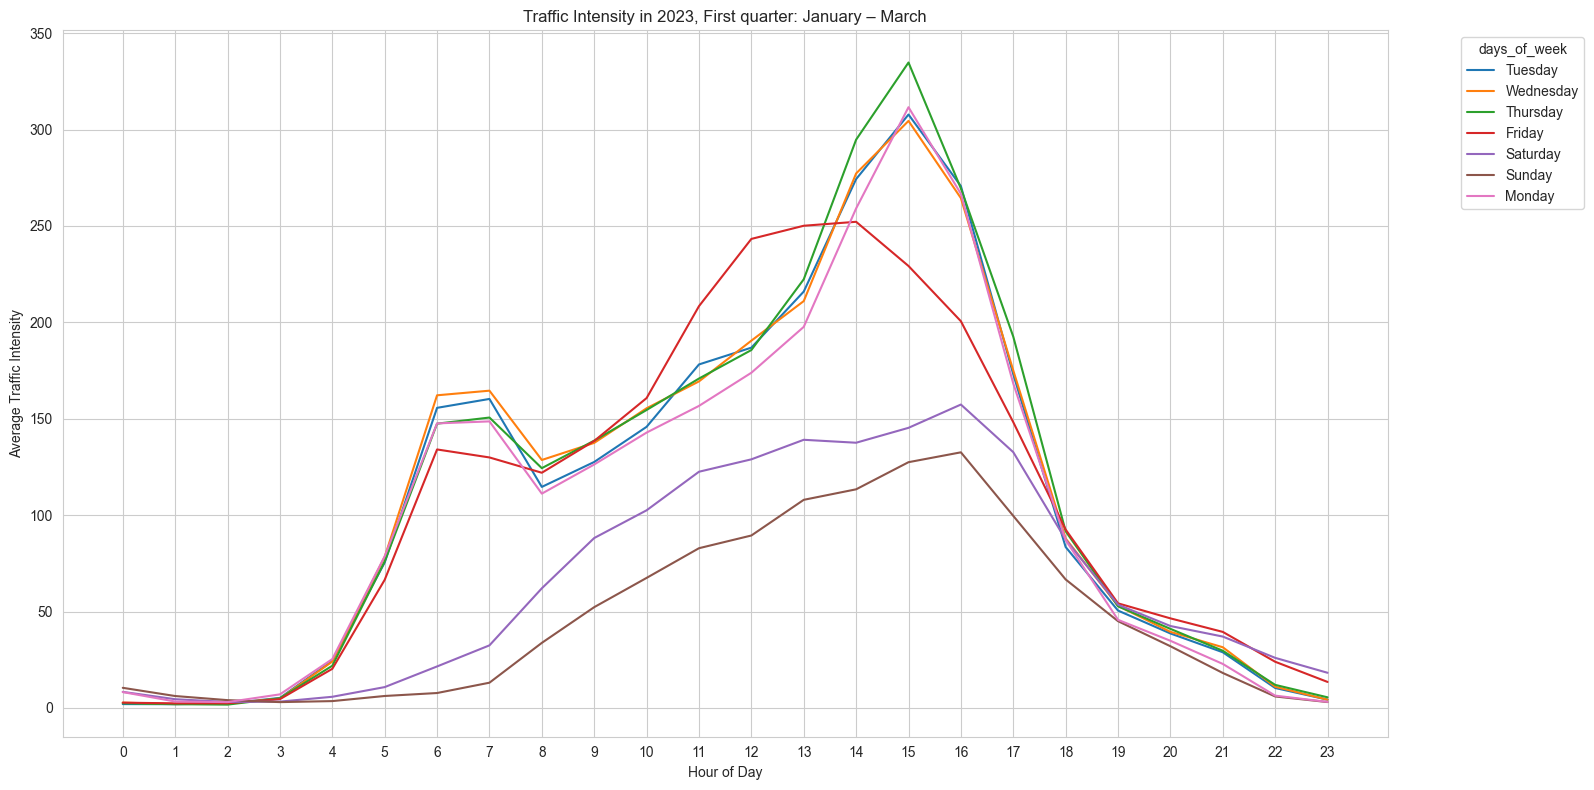

In [30]:
plt.figure(figsize=(16, 8))
sns.set_style("whitegrid")

sns.lineplot(x='hourOfDay', y='intensity', hue='days_of_week',
             data=data_preprocessed[data_preprocessed['month_number']<=3],
             estimator='mean', errorbar=None)

plt.title(f'Traffic Intensity in 2023, First quarter: January – March')
plt.xlabel('Hour of Day')
plt.ylabel('Average Traffic Intensity')
plt.xticks(range(0, 24))
plt.legend(title='days_of_week', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()

plt.show()

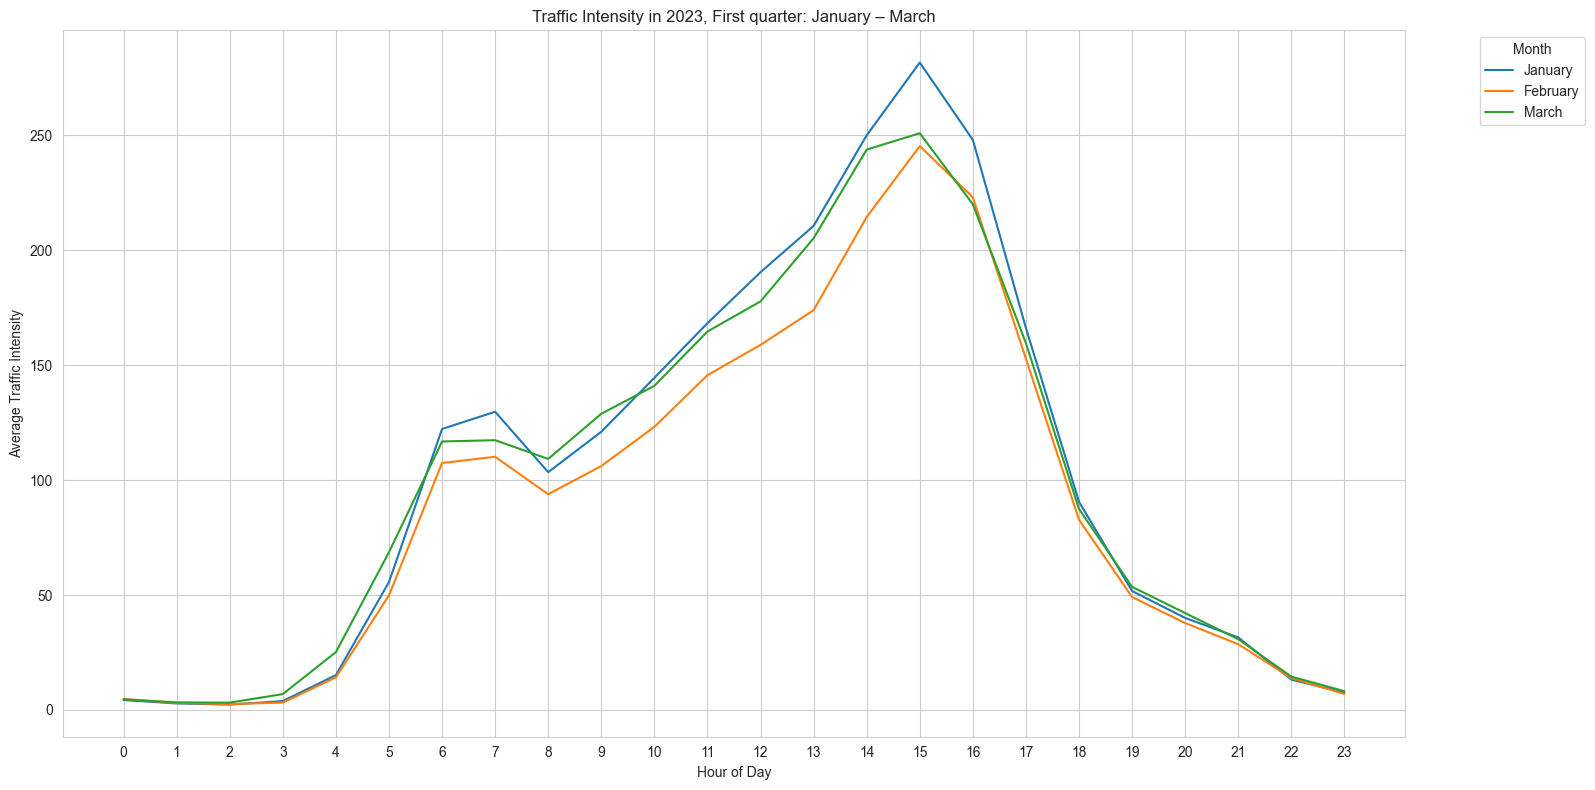

In [31]:
plt.figure(figsize=(16, 8))
sns.set_style("whitegrid")

sns.lineplot(x='hourOfDay', y='intensity', hue='month',
             data=data_preprocessed[(data_preprocessed['year'] == 2023) &(data_preprocessed['month_number']<=3)],
             estimator='mean', errorbar=None)

plt.title(f'Traffic Intensity in 2023, First quarter: January – March')
plt.xlabel('Hour of Day')
plt.ylabel('Average Traffic Intensity')
plt.xticks(range(0, 24))
plt.legend(title='Month', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()

plt.show()

In [32]:
data_preprocessed.to_csv('bergheim_EDA.csv')

#### One-hot encoding

In [34]:
data.vehicleType.unique()

array(['car', 'motorcycle', 'van', 'lorry'], dtype=object)

In [35]:
encoder = OneHotEncoder(sparse_output=False)
vehicle_type_encoded = encoder.fit_transform(data[['vehicleType']])
vehicle_type_encoded_df = pd.DataFrame(vehicle_type_encoded, columns=encoder.get_feature_names_out(['vehicleType']))

In [36]:
# One-hot encode locations
encoder = OneHotEncoder(sparse_output=False)
vehicle_type_encoded = encoder.fit_transform(data[['vehicleType']])
vehicle_type_encoded_df = pd.DataFrame(vehicle_type_encoded, columns=encoder.get_feature_names_out(['vehicleType']))

In [38]:
data_vehicle_encoded= pd.concat([data, vehicle_type_encoded_df], axis=1)

#### Traffic intensity by vehicleType

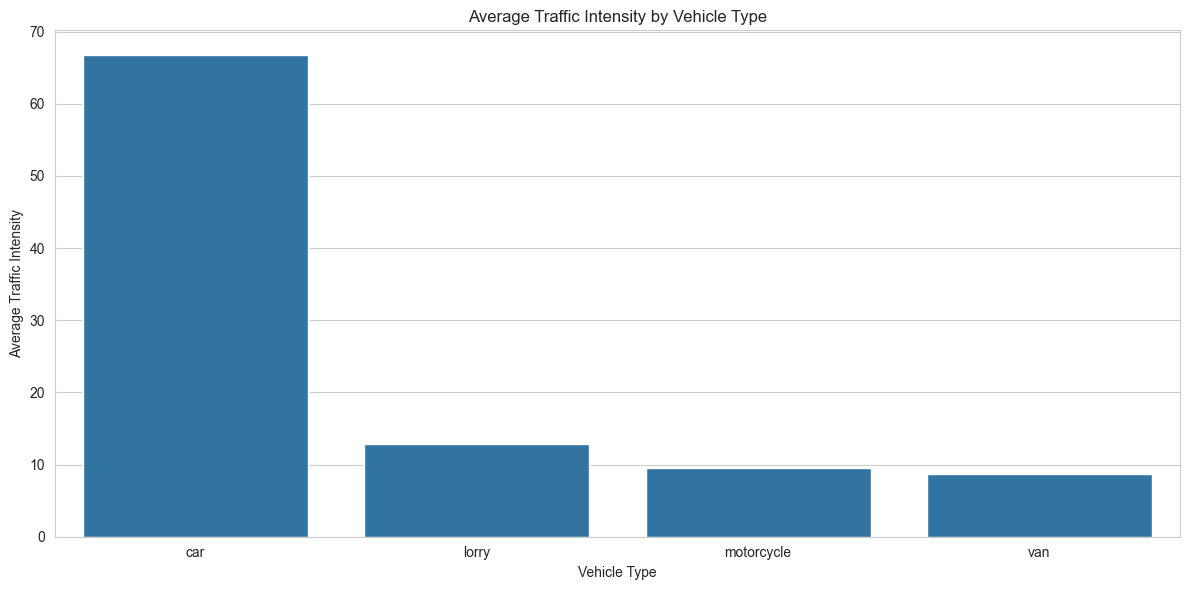

In [39]:
vehicle_types = encoder.categories_[0]
average_intensities = [data_vehicle_encoded.loc[data_vehicle_encoded[vehicle_type] == 1, 'intensity'].mean() for vehicle_type in vehicle_type_encoded_df.columns]
plt.figure(figsize=(12, 6))
sns.barplot(x=vehicle_types, y=average_intensities)
plt.title('Average Traffic Intensity by Vehicle Type')
plt.xlabel('Vehicle Type')
plt.ylabel('Average Traffic Intensity')
plt.tight_layout()
plt.show()